In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
experiment_name = 'd01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [3]:
time_window = 25
time_step = 25
trial_bin_size = 20
n_splits = 1000
group_dict = OrderedDict([('1 (very dissimilar)',[11]),('1 (dissimilar)',[12]),('1 (similar)',[13]),('2',[20])])
train_labels = ['1 (very dissimilar)','2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [4]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)

        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

interp = eeg_decoder.Interpreter(clfr, subtitle='hyperplane')
interp.save_results(timestamp=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [4]:
interp = eeg_decoder.Interpreter()
interp.load_results('hyperplane')

1
Significant timepoints: [160 184 208 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568
 592 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952]
2
Significant timepoints: [184 208 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568 592
 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952]
Saving output\figures\hyperplane1v2.pdf
Saving output\figures\hyperplane1v2.png


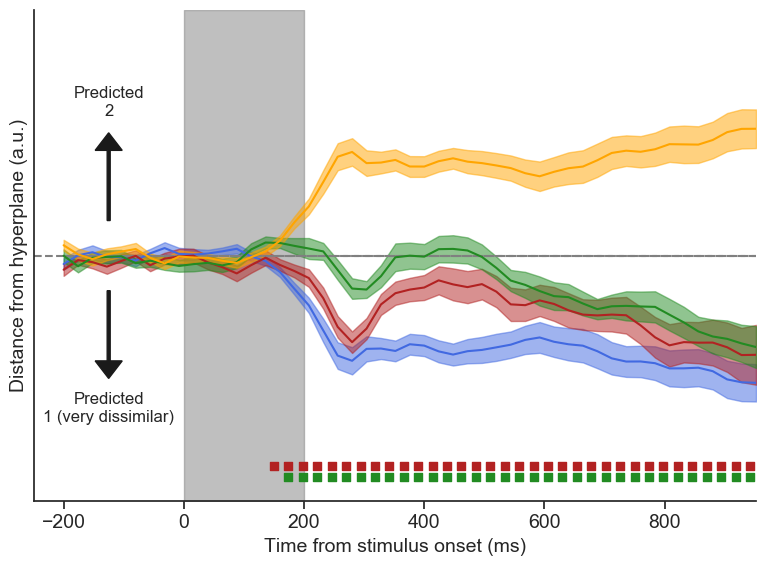

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.close()

sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))

interp.plot_hyperplane(
    stim_time=[0,200], 
    significance_testing_pair=[(1,3),(2,3)],
    sig_y=-3,
    test_from_zero=False,
    ylim=[-3.5,3.5],stim_label_xy=[120,3.1],
    label_text_ys=[-1.95,1.95],label_text_x=-125,
    arrow_ys=[-.5,.5],
    savefig=True,subtitle='1v2',legend_pos=None)

# break it up into time windows

In [8]:
import numpy as np
import pandas as pd
def get_condition_means(conf_scores, time_idx=None):

    if time_idx is None:
        delay_acc =np.mean(np.mean(interp.confidence_scores,2),1)
    else:
        delay_acc =np.mean(np.mean(interp.confidence_scores[:,time_idx],2),1)

    subject_means = pd.DataFrame(delay_acc,columns=list(group_dict.keys()))
    labels = list(group_dict.keys())
    subject_means['Subject'] = np.arange(exp.nsub)

    x = subject_means.melt(id_vars='Subject',value_vars=labels,var_name='Condition',value_name='Distance from Hyperplane')
    condition_means = x.groupby('Condition').mean()['Distance from Hyperplane'].to_numpy()
    return x, condition_means

In [9]:
stim_time_idx = (interp.t>0)&(interp.t<200)
first_half_time_idx = (interp.t>200)&(interp.t<600)
second_half_time_idx = (interp.t>600)
x_0, condition_means_0 = get_condition_means(interp.confidence_scores,stim_time_idx)
x_1, condition_means_1 = get_condition_means(interp.confidence_scores,first_half_time_idx)
x_2, condition_means_2 = get_condition_means(interp.confidence_scores,second_half_time_idx)

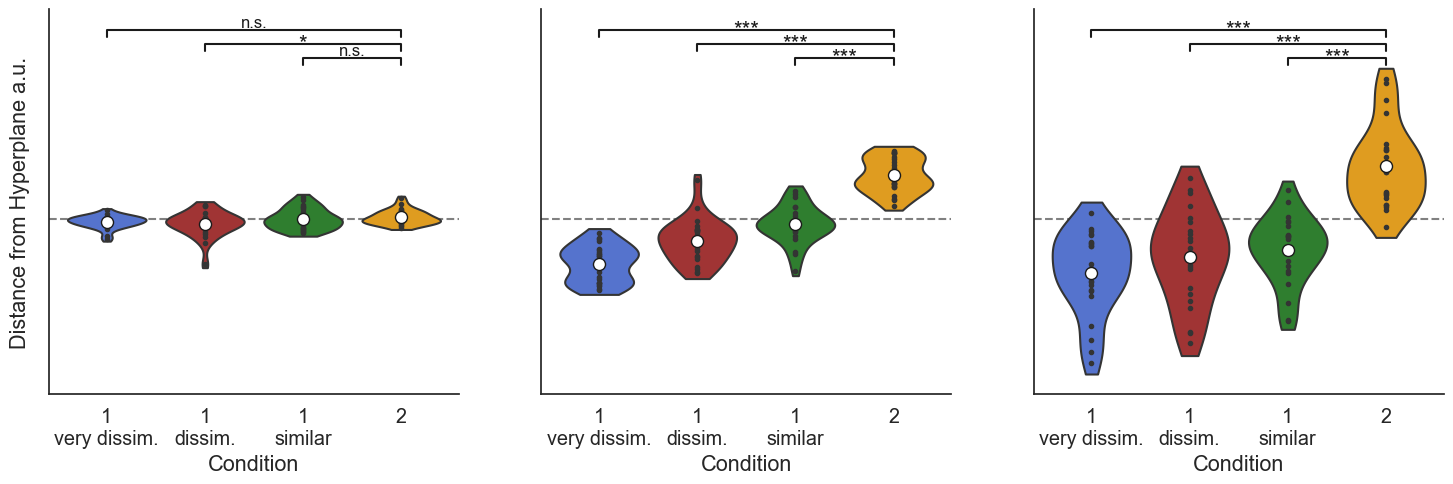

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=1.3,style='white',rc=custom_params)

fig,ax = plt.subplots(1,3,figsize=(18,5),sharey=True)

### Stim
ax[0].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_0,ax=ax[0],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[0].scatter(
    x = [0,1,2,3],
    y = [condition_means_0[2],condition_means_0[0],condition_means_0[1],condition_means_0[3]],
    c = 'white', edgecolors='k',s=75)
ax[0].set_ylabel('Distance from Hyperplane a.u.')
ax[0].set_yticklabels([])

stat_y,stat_h = 5.2, .2
ax[0].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(1.5, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

stat_y,stat_h = 4.8, .2
ax[0].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(2, stat_y+stat_h-.25, '*', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.4, .2
ax[0].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(2.5, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

### First half
ax[1].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_1,ax=ax[1],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[1].scatter(
    x = [0,1,2,3],
    y = [condition_means_1[2],condition_means_1[0],condition_means_1[1],condition_means_1[3]],
    c = 'white', edgecolors='k',s=75)
ax[1].set_ylabel('')

stat_y,stat_h = 5.2, .2
ax[1].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(1.5, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.8, .2
ax[1].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(2, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.4, .2
ax[1].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(2.5, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

### Second half
ax[2].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_2,ax=ax[2],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[2].scatter(
    x = [0,1,2,3],
    y = [condition_means_2[2],condition_means_2[0],condition_means_2[1],condition_means_2[3]],
    c = 'white', edgecolors='k',s=75)
ax[2].set_ylabel('')

stat_y,stat_h = 5.2, .2
ax[2].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(1.5, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.8, .2
ax[2].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(2, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.4, .2
ax[2].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(2.5, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

for a in ax:
    a.set_ylim(-5,6)
    a.set_xticklabels(['1\nvery dissim.','1\ndissim.','1\nsimilar','2'])

plt.savefig('output/figures/hyperplane_violin.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/hyperplane_violin.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [27]:
x_0['window'] = 'stim'
x_1['window'] = 'first_half'
x_2['window'] = 'second_half'
all_windows = pd.concat([x_0,x_1,x_2])

In [29]:
all_windows.groupby(['window','Condition']).agg(['mean','std'])['Distance from Hyperplane']

mean       std
window      Condition                              
first_half  1 (dissimilar)      -0.620835  0.612177
            1 (similar)         -0.149183  0.530431
            1 (very dissimilar) -1.275065  0.515634
            2                    1.259381  0.491792
second_half 1 (dissimilar)      -1.075626  1.306249
            1 (similar)         -0.884748  0.948823
            1 (very dissimilar) -1.532497  1.156745
            2                    1.519835  1.153168
stim        1 (dissimilar)      -0.128842  0.363669
            1 (similar)          0.017229  0.291325
            1 (very dissimilar) -0.073936  0.186482
            2                    0.060890  0.205560

In [41]:
import pingouin
def grab_cond_and_window(cond, window):
    return all_windows.query(f'window=="{window}" & Condition=="{cond}"')['Distance from Hyperplane']

# different from 0

In [50]:
# STIM
pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "stim"),y=0),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "stim"),y=0),
pingouin.ttest(grab_cond_and_window("1 (similar)", "stim"),y=0),
pingouin.ttest(grab_cond_and_window("2", "stim"),y=0)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.942343,23,two-sided,0.064439,"[-0.15, 0.0]",0.396479,1.067,0.460686
T-test,-1.735628,23,two-sided,0.096010,"[-0.28, 0.02]",0.354284,0.787,0.383478
T-test,0.289719,23,two-sided,0.774627,"[-0.11, 0.14]",0.059139,0.223,0.058888
T-test,1.451155,23,two-sided,0.160240,"[-0.03, 0.15]",0.296216,0.541,0.285041


In [53]:
# First Half
pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "first_half"),y=0),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "first_half"),y=0),
pingouin.ttest(grab_cond_and_window("1 (similar)", "first_half"),y=0),
pingouin.ttest(grab_cond_and_window("2", "first_half"),y=0)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-12.114260,23,two-sided,1.828897e-11,"[-1.49, -1.06]",2.472813,4.796e+08,1.000000
T-test,-4.968262,23,two-sided,5.046266e-05,"[-0.88, -0.36]",1.014142,500.628,0.997381
T-test,-1.377828,23,two-sided,1.815158e-01,"[-0.37, 0.07]",0.281248,0.495,0.261818
T-test,12.545311,23,two-sided,9.058152e-12,"[1.05, 1.47]",2.560801,9.312e+08,1.000000


In [54]:
# Second Half
pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "second_half"),y=0),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "second_half"),y=0),
pingouin.ttest(grab_cond_and_window("1 (similar)", "second_half"),y=0),
pingouin.ttest(grab_cond_and_window("2", "second_half"),y=0)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.490346,23,two-sided,0.000001,"[-2.02, -1.04]",1.324836,1.437e+04,0.999989
T-test,-4.034047,23,two-sided,0.000517,"[-1.63, -0.52]",0.823446,62.671,0.971320
T-test,-4.568148,23,two-sided,0.000137,"[-1.29, -0.48]",0.932469,204.692,0.992031
T-test,6.456686,23,two-sided,0.000001,"[1.03, 2.01]",1.317965,1.336e+04,0.999987


# different from 2

In [68]:
# STIM
pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "stim"),grab_cond_and_window("2", "stim"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "stim"),grab_cond_and_window("2", "stim"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (similar)", "stim"),grab_cond_and_window("2", "stim"),paired=True)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.703191,23,two-sided,0.102010,"[-0.3, 0.03]",0.687003,0.752,0.896552
T-test,-2.170539,23,two-sided,0.040538,"[-0.37, -0.01]",0.642311,1.536,0.853814
T-test,-0.579683,23,two-sided,0.567764,"[-0.2, 0.11]",0.173180,0.25,0.128557


In [69]:
# first_half
pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "first_half"),grab_cond_and_window("2", "first_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "first_half"),grab_cond_and_window("2", "first_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (similar)", "first_half"),grab_cond_and_window("2", "first_half"),paired=True)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-12.352187,23,two-sided,1.238136e-11,"[-2.96, -2.11]",5.030123,6.932e+08,1.0
T-test,-10.195575,23,two-sided,5.297809e-10,"[-2.26, -1.5]",3.386210,2.013e+07,1.0
T-test,-9.831495,23,two-sided,1.052421e-09,"[-1.7, -1.11]",2.753917,1.057e+07,1.0


In [70]:
# second_half 
pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "second_half"),grab_cond_and_window("2", "second_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "second_half"),grab_cond_and_window("2", "second_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (similar)", "second_half"),grab_cond_and_window("2", "second_half"),paired=True)])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.477476,23,two-sided,0.000001,"[-4.03, -2.08]",2.642809,1.397e+04,1.0
T-test,-5.405526,23,two-sided,0.000017,"[-3.59, -1.6]",2.106555,1329.046,1.0
T-test,-6.262303,23,two-sided,0.000002,"[-3.2, -1.61]",2.277176,8772.558,1.0
